# Credit Card Fraud Detection

## Synopsis

Credit card companies handle numerous credit card transactions each day and there could be some cases of fraudulent transactions, where customers are charged for items they did not purchase. As such, it is important for companies to detect these fraudulent transactions to improve customer security and build up customer confidence in the company. In this project, we will explore some methods to resolve data imbalance and use logistic regression to classify the transactions as safe or fraudulent.

## Data

The dataset is taken from Kaggle and can be obtained [here](https://www.kaggle.com/mlg-ulb/creditcardfraud).

The dataset contains transactions made by credit cards in September 2013 by European cardholders. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. The feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## Loading in the Data

Load in the libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

Load in the csv file and check its first few rows.

In [3]:
credit = pd.read_csv("creditcard.csv")

In [4]:
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
credit.shape

(284807, 31)

## Data Preparation

Separate the output variable from the predictor variables.

In [6]:
output_var = credit['Class']
credit.drop('Class', axis=1, inplace=True)

Normalize the 'Amount' column and remove the 'Time' column.

In [7]:
credit['norm_amount'] = StandardScaler().fit_transform(credit['Amount'].values.reshape(-1, 1))
credit.drop(['Time','Amount'],axis=1, inplace=True)
credit.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,norm_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403


## Data Imbalance

We count the number of each class as follows:

In [8]:
class_count = output_var.value_counts()
class_count

0    284315
1       492
Name: Class, dtype: int64

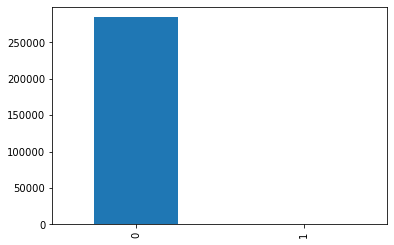

In [9]:
class_count.plot(kind = 'bar')

From the values and plot, there appears to be severe data imbalance. Very few transactions are fraudulent while most of the transactions are safe. This needs to be resolved as predictive models developed using conventional machine learning algorithms could be biased and inaccurate. Such models would have a bias towards classes which have a high number of instances, such as in this case, safe transactions. These models would tend to predict the transactions as safe and treat the fraudulent transactions as noise. Thus, there would be a high probability of misclassification of fraudulent transactions as safe, which is definitely not ideal.

One of the ways to resolve data imbalance is to resample the dataset. This can be done by undersampling or oversampling. In this case, we will use oversampling as undersampling would result in too little data.

## Oversampling

Two different oversampling techniques will be tested. They are:

- RandomOverSampler
- SMOTE (Synthetic Minority Oversampling Technique)

Split the data into training and test sets. Note that we only perform oversampling after data splitting and on the training data so that no information will from the test data will be used in model training.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(credit, output_var, test_size=0.3, random_state=42)

### RandomOverSampler

RandomOverSampler involves oversampling the minority class by picking samples at random with replacement. We are going to check the number of rows before and after sampling.

In [11]:
# Check number of rows before oversampling
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 356
Before OverSampling, counts of label '0': 199008 



In [12]:
# Apply RandomOverSampler
over_sample = RandomOverSampler(random_state=42)
x_train_ros, y_train_ros = over_sample.fit_resample(x_train, y_train.ravel())
# Check number of rows after oversampling
print("After OverSampling, counts of label '1': {}".format(sum(y_train_ros==1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_ros==0))) 

After OverSampling, counts of label '1': 199008
After OverSampling, counts of label '0': 199008 



### SMOTE (Synthetic Minority Oversampling Technique)

SMOTE first selects a minority class instance 'a' at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors 'b' at random and connecting 'a' and 'b' to form a line segment. The synthetic instances are generated as a convex combination of the two chosen instances 'a' and 'b'. 

In [13]:
# Apply SMOTE
over_sample = SMOTE(random_state=42)
x_train_smote, y_train_smote = over_sample.fit_resample(x_train, y_train.ravel())
# Check number of rows after oversampling
print("After OverSampling, counts of label '1': {}".format(sum(y_train_smote==1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_smote==0))) 

After OverSampling, counts of label '1': 199008
After OverSampling, counts of label '0': 199008 



## Model Building

Logistic regression will be used to model the data. Logistic Regression is a classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 or 0, or in this case, fraudulent or safe.

The model will first be run on the imbalanced data, followed by  the data after oversampling (RandomOverSampler and SMOTE). The models on the 3 different datasets will then be compared.

### 1) Logistic Regression on imbalanced dataset

Fit the training data into logistic regression and use the model to predict on the test data.

In [14]:
lg = LogisticRegression()
lg.fit(x_train, y_train)

y_pred = lg.predict(x_test)

### Evaluation

Plot the confusion matrix. A confusion matrix is a table that is often used to describe the performance of a classification model. It shows the number of true positives, true negatives, false positives and false negatives.

**True Positives (TP)** - Actual class is 1 and predicted class is 1 (safe transactions accurately classified as safe)

**True Negatives (TN)** - Actual class is 0 and predicted class is 0 (fraudulent transactions accurately classified as fraudulent)

**False Positives (FP)** - Actual class is 0 but predicted class is 1 (safe transactions wrongly classified as fraudulent)

**False Negatives (FN)** - Actual class is 1 but predicted class is 0 (fraudulent transactions wrongly classified as safe)

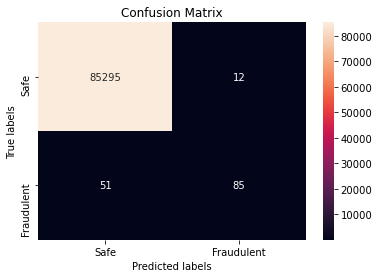

In [15]:
cm = confusion_matrix(y_test, y_pred)

# Create graphics for confusion matrix
labels = ['Safe','Fraudulent']
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt="d"); 

# Labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

There appears to be a large number of transactions classified correctly as safe or fraudulent. However, there are 51 false negatives, i.e. fraudulent transactions that were predicted as safe, which the model needs to improve on.

Since this is an imbalanced dataset, we print out the classification report, which shows the accuracy, precision, recall, f1 score and support of the model.

**Accuracy** - Ratio of correctly predicted observations to the total observations, i.e. TP+TN/TP+FP+FN+TN

**Precision** - Ratio of correctly predicted positive observations to the total predicted positive observations, i.e. TP/TP+FP

**Recall** - Ratio of correctly predicted positive observations to all the observations in positive class, i.e. TP/TP+FN

**F1 score** - Weighted average of precision and recall, usually more useful than accuracy, especially if you have an uneven class distribution, i.e 2*(Recall * Precision) / (Recall + Precision)

**Support** - Number of actual occurrences of the class in the dataset

In [16]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.99940   0.99986   0.99963     85307
           1    0.87629   0.62500   0.72961       136

    accuracy                        0.99926     85443
   macro avg    0.93785   0.81243   0.86462     85443
weighted avg    0.99921   0.99926   0.99920     85443



The model has a precision of 0.88, recall of 0.63 and f1 score of 0.73, which shows that the model does relatively well.

Now, we plot a Receiver Operating Characteristic (ROC) curve. It plots the true positive rate (TPR) versus the false positive rate (FPR) as a function of the model’s threshold for classifying a positive. We then proceed to compute the Area under the curve (AUC), which is a metric to calculate the overall performance of a classification model based on area under the ROC curve.

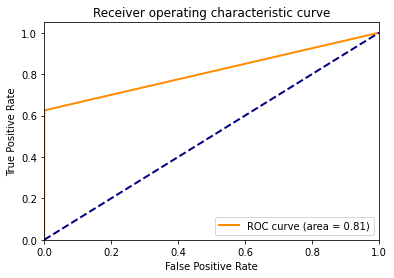

In [17]:
# Get false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

### 2) Logistic Regression on oversampled dataset (RandomOverSampler)

In [18]:
lg_ros = LogisticRegression()
lg_ros.fit(x_train_ros, y_train_ros)

y_pred = lg_ros.predict(x_test)

### Evaluation

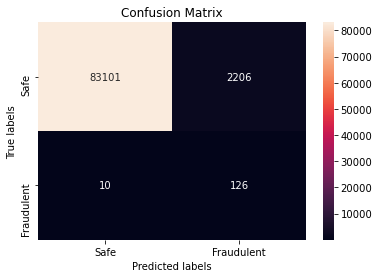

In [19]:
cm = confusion_matrix(y_test, y_pred)

# Create graphics for confusion matrix
labels = ['Safe','Fraudulent']
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt="d"); 

# Labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

There appears to be 10 false negatives, which is much lower than the unbalanced dataset. However, there are significantly more false positives.

In [20]:
accuracy_ros = accuracy_score(y_test, y_pred)
precision_ros = precision_score(y_test, y_pred)
recall_ros = recall_score(y_test, y_pred)
f1_ros = f1_score(y_test, y_pred)

print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.99988   0.97414   0.98684     85307
           1    0.05403   0.92647   0.10211       136

    accuracy                        0.97406     85443
   macro avg    0.52696   0.95031   0.54447     85443
weighted avg    0.99837   0.97406   0.98543     85443



As expected, it has a low precision of 0.05 but a high recall of 0.93.

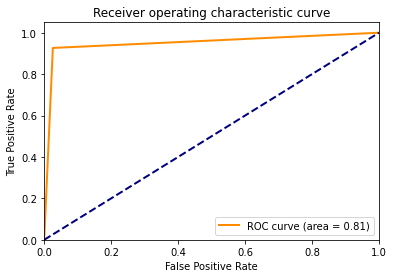

In [21]:
# Get false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc_ros = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

It has an AUC score of 0.95, which is higher than that of the imbalanced dataset.

### 3) Logistic Regression on oversampled dataset (SMOTE)

In [22]:
lg_smote = LogisticRegression()
lg_smote.fit(x_train_smote, y_train_smote)

y_pred = lg_smote.predict(x_test)

### Evaluation

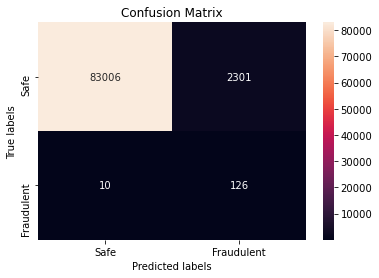

In [23]:
cm = confusion_matrix(y_test, y_pred)

# Create graphics for confusion matrix
labels = ['Safe','Fraudulent']
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt="d"); 

# Labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

It has similar false negatives to the oversampled data using RandomOverSampler but higher false positives.

In [24]:
accuracy_smote = accuracy_score(y_test, y_pred)
precision_smote = precision_score(y_test, y_pred)
recall_smote = recall_score(y_test, y_pred)
f1_smote = f1_score(y_test, y_pred)

print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.99988   0.97303   0.98627     85307
           1    0.05192   0.92647   0.09832       136

    accuracy                        0.97295     85443
   macro avg    0.52590   0.94975   0.54230     85443
weighted avg    0.99837   0.97295   0.98486     85443



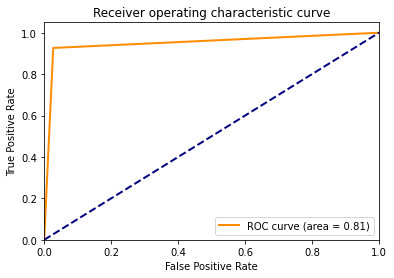

In [25]:
# Get false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc_smote = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

It has similar AUC score to the oversampled data using RandomOverSampler.

## Results

For a better comparison, we create the following dataframe.

In [29]:
data = {'Accuracy' : [accuracy,accuracy_ros,accuracy_smote], 
        'Precision' : [precision, precision_ros, precision_smote],
        'Recall' : [recall, recall_ros, recall_smote],
        'F1' : [f1,f1_ros,f1_smote],
        'AUC' : [roc_auc,roc_auc_ros,roc_auc_smote]}
pd.DataFrame(data, index = ['Imbalanced', 'RandomOverSampler', 'SMOTE'])

,Accuracy,Precision,Recall,F1,AUC
Imbalanced,0.999263,0.876289,0.625000,0.729614,0.812430
RandomOverSampler,0.974065,0.054031,0.926471,0.102107,0.950306
SMOTE,0.972953,0.051916,0.926471,0.098322,0.949749


It would appear that the imbalanced dataset performs better overall based on the F1 score. However, if the cost of false positives is not too high, the company may consider using the model fitted with RandomOverSampler, since it predicts less false negatives so less fraudulent transactions will be passed off as safe.